# Model Portability Analysis - Part 2
This work is &copy; 2023 by [William Caban](https://www.linkedin.com/in/williamcaban/) and licensed under [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1)<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>

---
## Goals of the project

To understand the goal and approach of this analysis, refer to Part 1.

**NOTE** Randomization of node positioning:

The main difference of the dataset in ***Part 2*** is the addition of the randomization for node positioning. This is done to decouple the abstracted node identifier (e.g., node1, node2, node3) and its characteristics (e.g., num pods, memory, etc.), from the specific label of node1, node2, etc. To achieve this, for each role, e.g., the control plane, we append an identical dataset for each node permutation (swap node1 with node2, swap node1 with node3, swap node2 with node3, etc.)

### About the approach

This analysis includes:
- Running analysis using `BalancedRandomForestClassifier`
- Creating per-role node permutations to decouple the node position for better generalization


## Section 1: Cleaning raw datasets

In [1]:
import pandas as pd
import re, os, sys
import logging
import importlib
import pprint

# Need to chdir to parent due to notebook folder in repo
os.chdir(os.path.dirname(os.getcwd()))

# import custom classes
from src.config import Config
from src.data_wrangling import DataWrangle
from src.data_transformation import DataTransformation

os.environ['LOG_LEVEL']='INFO'

In [2]:
# Load the general mapping for features datatypes and attributes for y_labels definition
global_config = Config(
    config_file="mapping/mapping.yaml", 
    y_map_file="mapping/labels-definition.yaml"
)

# Using custom utility class for manipulation of the dataframes
data_wrangler=DataWrangle(mapping_set=global_config.config, 
                          y_map_set=global_config.y_map, 
                          logger=global_config.logger)

2023-09-05 17:51:39,285 [INFO] Successfully loaded the config YAML file.
2023-09-05 17:51:39,312 [INFO] Successfully loaded the y-map YAML file.



        #######################################################################################################
            For controlling verbosity of messages set LOG_LEVEL environment variable (e.g., INFO, DEBUG)
        #######################################################################################################
        


***NOTE*** The dataset for part-2 adds randomization for nodes positioning

In [56]:
# Load dataset and randomize_nodes
fname_combined="data/wrangle/combined-all.parquet"
data_wrangler.load_dataset(fname_combined, randomize_nodes=True)

# Getting a local copy of the dataframe for
# testing without affecting the original one
df_raw=data_wrangler.df.copy()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Columns: 591 entries, run_id to node3_attach
dtypes: bool(163), datetime64[ns](1), float64(325), string(1), uint32(101)
memory usage: 106.4 MB


In [57]:
# Instantiate custom utility class for data transformation
# need to supply the attributes for y_labels definition 
dt_util = DataTransformation(
    y_label_yellow=data_wrangler.y_label_yellow,
    y_label_red=data_wrangler.y_label_red,
    y_label_red_fatal=data_wrangler.y_label_red_fatal
)

# derive y_labels for dataset using custom thresholds
# (thresholds yellow=2% red=1% red(fatal_red)=0%)
dt_util.impute_y_label(df_raw,label_weight=[0.02,0.01,0])
df_raw.shape

2023-09-05 19:29:39,763 [WARNING] [impute_y_label] Known issue. Requires optimization for performance.
2023-09-05 19:29:39,763 [WARNING] [impute_y_label] Known issue. Requires optimization for performance.
2023-09-05 19:29:39,763 [WARNING] [impute_y_label] Known issue. Requires optimization for performance.
2023-09-05 19:29:39,763 [WARNING] [impute_y_label] Known issue. Requires optimization for performance.


(35040, 595)

In [52]:
# Aggregate datasets by cluster type
# (only modifying the `source` column)
dt_util.normalize_sources(df_raw)

# show new aggregated results
dt_util.y_by_group(df_raw)

----
By y_label:
 y_label
green     20790
red       12460
yellow     1790
Name: y_label, dtype: int64

----
By source by y_label:
 source   y_label
compact  green      14820
         red        12140
         yellow      1780
mno      green       5970
         red          320
         yellow        10
Name: source, dtype: int64


In [6]:
# drop unnecesary columns and remove duplicated rows
# get a clean dataset
df_clean=dt_util.get_clean_dataset(df_raw)

# shape of clean dataset
df_clean.shape

(13309, 468)

In [7]:
# show the aggregate of clean dataset
dt_util.y_by_group(df_clean)

----
By y_label:
 y_label
green     11895
red         692
yellow      722
Name: y_label, dtype: int64

----
By source by y_label:
 source   y_label
compact  green      5925
         red         557
         yellow      712
mno      green      5970
         red         135
         yellow       10
Name: source, dtype: int64


In [8]:
# Showing final list of columns in clean dataset
# to be used for the training of the ML models
##df_clean.columns.to_list()

## Section 2: Comparing Machine Learning Models (cont.)

The dataset contains a label `y_label`, which can be `green`, `yellow`, `red`. 

The experimentation in this section focuses on a more detailed analysis of handling unbalanced datasets. The work explores the use of the `BalancedRandomForestClassifier` algorithm from the [imbalanced-learn.org](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html) library.

In [9]:
# loading common ML libraries and setting defaults
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline

# Import Balanced Random Forest Classifier class
from imblearn.ensemble import BalancedRandomForestClassifier

import matplotlib.pyplot as plt 
import numpy as np

# import custom ML utility class
from src.custom_ml import CustomML

# global defaults
RANDOM_STATE=42
SPLIT_SIZE=0.25

In [10]:
# Get our full dataset X_data
ml_util = CustomML(X_data=df_clean.copy(),
                   random_state=RANDOM_STATE,
                   split_size=SPLIT_SIZE)

Compact cluster (7194, 467)
Multinode (mno) (6115, 467)
Loaded dataset with shape (13309, 467)


In [11]:
# Get a structure with per cluster datasets with
# keys ['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test']
X_clusters = ml_util.get_xy_by_cluster_type()

In [12]:
# Obtain a copy of the X,y split combined dataset
X_train=ml_util.X_train
y_train=ml_util.y_train

X_test=ml_util.X_test
y_test=ml_util.y_test

### 2.4 Balanced Random Forest Classifier

The dataset uses a target variable y_label with $0=green$, $1=red$ and $2=yellow$

Reference docs: [BalancedRandomForestClassifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#balancedrandomforestclassifier)

In [13]:
# First will do evaluation with the X,y combined dataset
X_train.shape , X_test.shape

((9981, 465), (3328, 465))

In [14]:
# Create a BalancedRandomForest model
brf_model = BalancedRandomForestClassifier(
                n_estimators = 100, 
                criterion = 'gini', # 'entropy', 
                max_features = 'log2',
                n_jobs = -1, # num of parallel jobs, when -1 uses all processors
                class_weight = 'balanced',
                random_state = RANDOM_STATE)

In [15]:
# Without scaling data
brf = Pipeline([
    ('brf_model', brf_model)
])

In [16]:
brf.fit(X_train, y_train)

Pipeline(steps=[('brf_model',
                 BalancedRandomForestClassifier(class_weight='balanced',
                                                max_features='log2', n_jobs=-1,
                                                random_state=42))])

           accuracy_score	0.9912860576923077
  balanced_accuracy_score	0.9710571599463881
                 f1_score	0.9582679821630964
          precision_score	0.9467268413653049
             recall_score	0.9710571599463881
       mean_squared_error	0.012319711538461538


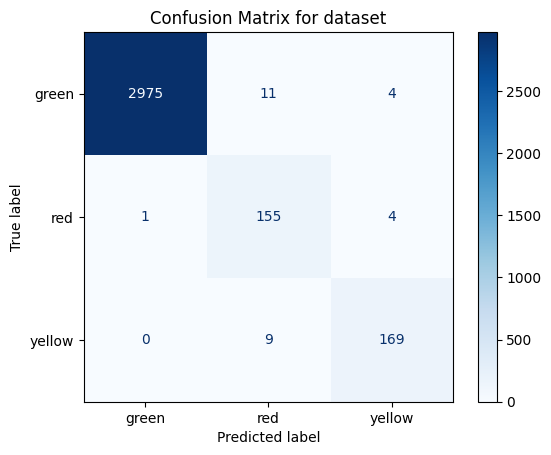

In [17]:
# Determine model scores without scaling
y_pred_brf=brf.predict(X_test)
_ = ml_util.get_model_scores(y_test, y_pred_brf)

ml_util.show_confusion_matrix(y_test, y_pred_brf)

**Discussion**

We have excellent scores using the combined dataset. In the next part, we determine if we can use a model trained in one cluster type to predict the other.

In [18]:
# Using the previously acquired structure with per cluster datasets with
# keys ['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test']
for k in X_clusters.keys():
    print(X_clusters[k].keys())

dict_keys(['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test'])
dict_keys(['X_full', 'X', 'y', 'X_train', 'y_train', 'X_test', 'y_test'])


In [125]:
# Create a BalancedRandomRandomForest model per cluster type COMPACT and MNO
brf_model_compact = BalancedRandomForestClassifier(
                n_estimators = 200, 
                criterion = 'gini', # 'entropy', 
                max_features = 'log2',
                n_jobs = -1, # num of parallel jobs, when -1 uses all processors
                class_weight = 'balanced',
                random_state = RANDOM_STATE)

brf_model_mno = BalancedRandomForestClassifier(
                n_estimators = 200, 
                criterion = 'gini', # 'entropy', 
                max_features = 'log2',
                n_jobs = -1, # num of parallel jobs, when -1 uses all processors
                class_weight = 'balanced',
                random_state = RANDOM_STATE)

In [126]:
# Pipeline for fitting the model for each cluster type

brf_compact = Pipeline([
    ('brf_model_compact', brf_model_compact)
])

brf_mno = Pipeline([
    ('brf_model_mno', brf_model_mno)
])

In [127]:
brf_compact.fit(X_clusters['compact']['X_train'], X_clusters['compact']['y_train'].astype('uint32'))

Pipeline(steps=[('brf_model_compact',
                 BalancedRandomForestClassifier(class_weight='balanced',
                                                max_features='log2',
                                                n_estimators=200, n_jobs=-1,
                                                random_state=42))])

In [128]:
brf_mno.fit(X_clusters['mno']['X_train'], X_clusters['mno']['y_train'].astype('uint32'))

Pipeline(steps=[('brf_model_mno',
                 BalancedRandomForestClassifier(class_weight='balanced',
                                                max_features='log2',
                                                n_estimators=200, n_jobs=-1,
                                                random_state=42))])

           accuracy_score	0.9866592551417455
  balanced_accuracy_score	0.9735426827263801
                 f1_score	0.9653048553896909
          precision_score	0.9583440567043365
             recall_score	0.9735426827263801
       mean_squared_error	0.016675931072818232


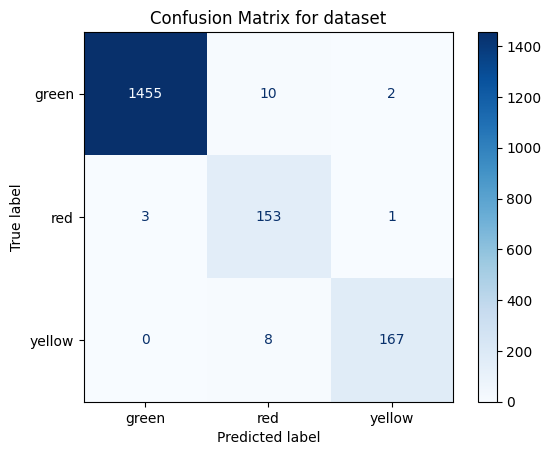

In [129]:
# Determine model scores for compact
y_pred_brf_compact=brf_compact.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('uint32'), y_pred_brf_compact)

ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('uint32'), y_pred_brf_compact)

           accuracy_score	0.9797253106605625
  balanced_accuracy_score	0.9328113067403153
                 f1_score	0.7254597387714855
          precision_score	0.647562339554126
             recall_score	0.9328113067403153
       mean_squared_error	0.026160889470241987


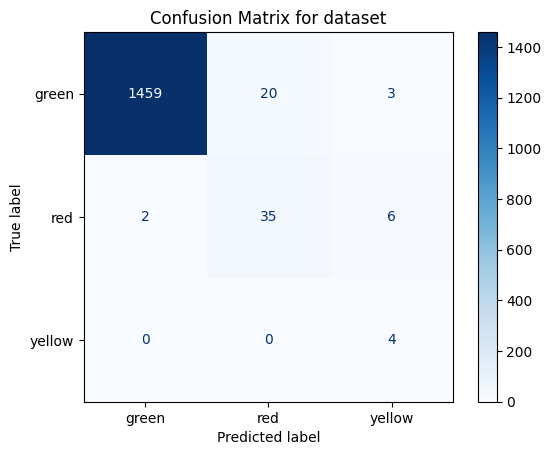

In [130]:
# Determine model scores for mno
y_pred_brf_mno=brf_mno.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('uint32'), y_pred_brf_mno)

ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('uint32'), y_pred_brf_mno)

**Discussion**

With these results, we can see very good results for both cluster types: `compact` and `mno`. Let's see how well a cluster type can predict the other and vice versa.

           accuracy_score	0.36363636363636365
  balanced_accuracy_score	0.34333971482074294
                 f1_score	0.19283566902318203
          precision_score	0.33252106478793275
             recall_score	0.34333971482074294
       mean_squared_error	0.7148463047743623


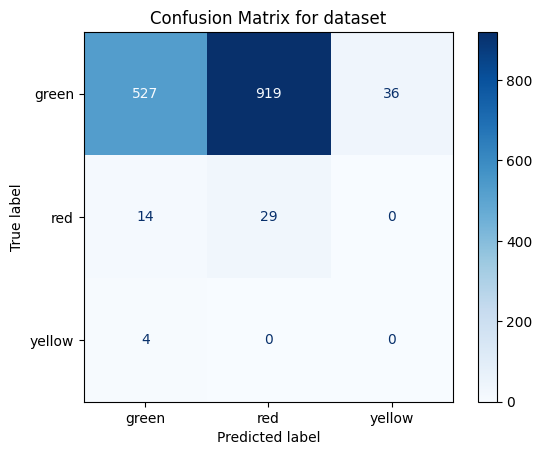

In [131]:
# Determine model scores for COMPACT predicting MNO
y_pred_brf_c2m=brf_compact.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('category'), y_pred_brf_c2m)

ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('category'), y_pred_brf_c2m)

           accuracy_score	0.4252362423568649
  balanced_accuracy_score	0.22880584464735143
                 f1_score	0.21704592170554757
          precision_score	0.24947752470688253
             recall_score	0.22880584464735143
       mean_squared_error	0.8615897720956087


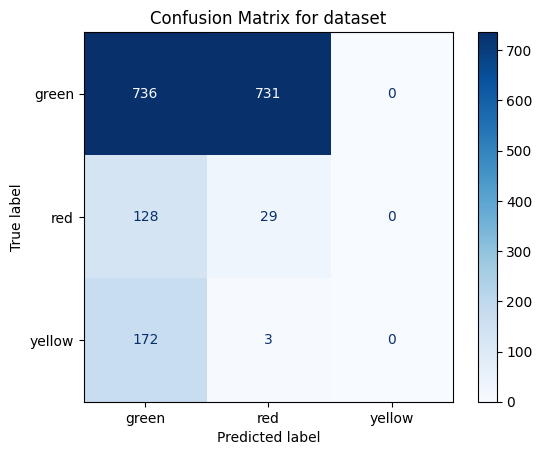

In [132]:
# Determine model scores for MNO predicting COMPACTS
y_pred_brf_m2c=brf_mno.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('category'), y_pred_brf_m2c)

ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('category'), y_pred_brf_m2c)

**Discussion**

These results show that using the "Balanced Random Forest Classifier" algorithm DOES NOT work for the model portability we wanted to achieve. Using a combined model remains the best performance option.

Next, we explore using Gradient Boosting algorithms.

### 2.5 Gradient Boosting Algorithms

This section analyzes the `Hierarchical Gradient Boosting (HGB)` classifier algorithm. The reason for using HGB is because it is the most optimized one from the Scikit-learn library, which is already used with other libraries. If a Gradient Boosting Algorithms is considered for the final models, it might be worth doing an analysis comparing with the `CatBoost` algorithm. The CatBoost is the one leading to the highest "accuracy" and "F1-scores", or the LightGBM, which seems to be the fastest one (see discussion in [1])

[1] A good comparison of the boosting ensemble techniques is discussed by [Boosting Techniques Battle: CatBoost vs XGBoost vs LightGBM vs scikit-learn GradientBoosting vs Hierarchical GB](https://kr-uttam.medium.com/boosting-techniques-battle-catboost-vs-xgboost-vs-lightgbm-vs-scikit-learn-gradientboosting-vs-c106afc85dda)

#### 2.5.1 Hierarchical Gradient Decent (HGB)

Docs for [sklearn.ensamble.HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier)

In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [28]:
# Adjusting hyperparameters to avoid overfitting
# See sklearn docs for HistGradientBoostingClassifier
LEARNING_RATE=0.1
MAX_ITER=10
MAX_LEAF_NODES=7
CLASS_WEIGHT='balanced'

hgb_model = HistGradientBoostingClassifier(
                loss='log_loss',
                learning_rate=LEARNING_RATE,
                max_iter=MAX_ITER,
                max_leaf_nodes=MAX_LEAF_NODES,
                class_weight=CLASS_WEIGHT,
                random_state = RANDOM_STATE)

In [29]:
# Without scaling data
hgb = Pipeline([
    ('hgb_model', hgb_model)
])

In [30]:
hgb.fit(X_train, y_train.astype('category'))

Pipeline(steps=[('hgb_model',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_iter=10, max_leaf_nodes=7,
                                                random_state=42))])

           accuracy_score	0.9906850961538461
  balanced_accuracy_score	0.973513850788521
                 f1_score	0.9618910500342782
          precision_score	0.9511760752688172
             recall_score	0.973513850788521
       mean_squared_error	0.021033653846153848


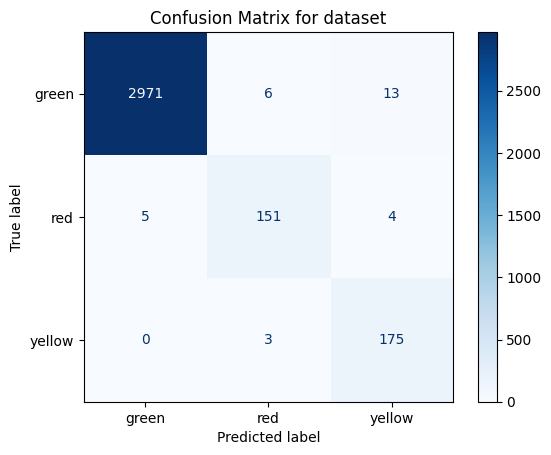

In [31]:
# Determine model scores without scaling
y_pred_hgb=hgb.predict(X_test)
_ = ml_util.get_model_scores(y_test, y_pred_hgb)

ml_util.show_confusion_matrix(y_test, y_pred_hgb)

**Discussion**

The combined dataset maintains an overall high performance, producing strong models. Using the HGB algorithm, we find it is easy for the model to overfit. Hence, we have to control the number of iterations and leaf nodes on the model. 

In [77]:
# Create a model per cluster type COMPACT and MNO

# Hyperparameters per-model
COMPACT_LEARNING_RATE=0.1
COMPACT_MAX_ITER=10
COMPACT_MAX_LEAF_NODES=7
COMPACT_CLASS_WEIGHT='balanced'

hgb_model_compact = HistGradientBoostingClassifier(
                loss='log_loss',
                learning_rate=COMPACT_LEARNING_RATE,
                max_iter=COMPACT_MAX_ITER,
                max_leaf_nodes=COMPACT_MAX_LEAF_NODES,
                class_weight=COMPACT_CLASS_WEIGHT,
                random_state = RANDOM_STATE)


In [72]:
# Pipeline for fitting the model for each cluster type
hgb_compact = Pipeline([
    ('hgb_model_compact', hgb_model_compact)
])

In [73]:
hgb_compact.fit(X_clusters['compact']['X_train'], X_clusters['compact']['y_train'].astype('category'))

Pipeline(steps=[('hgb_model_compact',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_iter=10, max_leaf_nodes=7,
                                                random_state=42))])

           accuracy_score	0.9894385769872152
  balanced_accuracy_score	0.9813889514315445
                 f1_score	0.9744338289399291
          precision_score	0.9676874662897105
             recall_score	0.9813889514315445
       mean_squared_error	0.02056698165647582


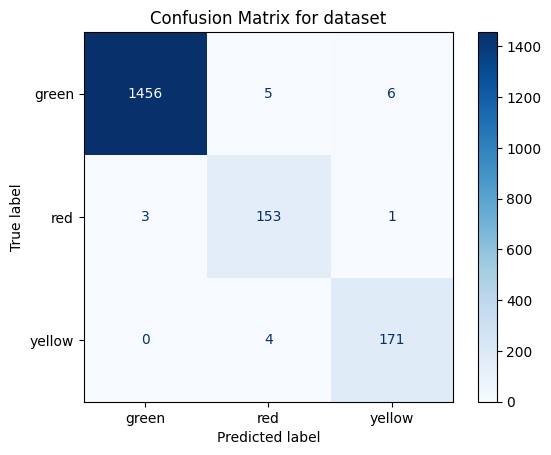

In [75]:
# Determine model scores for compact
y_pred_hgb_compact=hgb_compact.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('category'), y_pred_hgb_compact)

ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('category'), y_pred_hgb_compact)

In [110]:
# Hyperparameters per-model
MNO_LEARNING_RATE=0.01
MNO_MAX_ITER=1500
MNO_MAX_LEAF_NODES=15
MNO_CLASS_WEIGHT=None #'balanced'

hgb_model_mno = HistGradientBoostingClassifier(
                loss='log_loss',
                learning_rate=MNO_LEARNING_RATE,
                max_iter=MNO_MAX_ITER,
                max_leaf_nodes=MNO_MAX_LEAF_NODES,
                class_weight=MNO_CLASS_WEIGHT,
                random_state = RANDOM_STATE)

# Pipeline for fitting the model
hgb_mno = Pipeline([
    ('hgb_model_mno', hgb_model_mno)
])

hgb_mno.fit(X_clusters['compact']['X_train'], X_clusters['compact']['y_train'].astype('category'))

Pipeline(steps=[('hgb_model_mno',
                 HistGradientBoostingClassifier(learning_rate=0.01,
                                                max_iter=1500,
                                                max_leaf_nodes=15,
                                                random_state=42))])

           accuracy_score	0.9843034663178548
  balanced_accuracy_score	0.5567900072184038
                 f1_score	0.5919064225515839
          precision_score	0.6411452260655525
             recall_score	0.5567900072184038
       mean_squared_error	0.031393067364290386


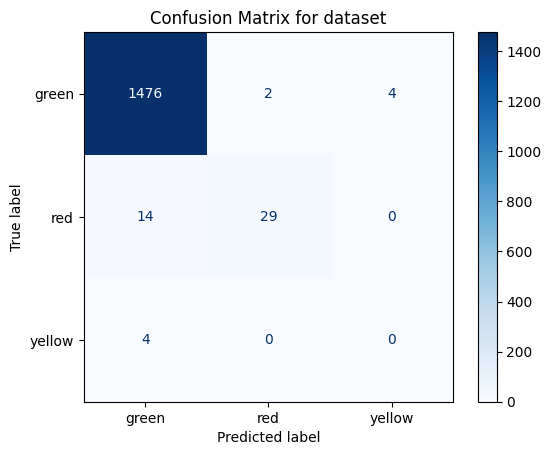

In [111]:
# Determine model scores for mno
y_pred_hgb_mno=hgb_mno.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('category'), y_pred_hgb_mno)

ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('category'), y_pred_hgb_mno)

**Discussion**

With the tuned model, we get good accuracy and mean squared error. The F1-score remains low in the "okay" range [1].

| F1 score  | Interpretation |
| --------- | ---------------|
| > 0.9     | Very good      |
| 0.8 - 0.9	| Good           |
| 0.5 - 0.8	| OK             |
| < 0.5	    | Not good       |

[1] See *Is F1 score good for imbalanced datasets* and *What is a good F1 score?* sections in the article about [F1-score](https://stephenallwright.com/good-f1-score/)

           accuracy_score	0.34466971877043817
  balanced_accuracy_score	0.20133069704673132
                 f1_score	0.2111247947454844
          precision_score	0.34143753544445055
             recall_score	0.20133069704673132
       mean_squared_error	2.3191628515369525


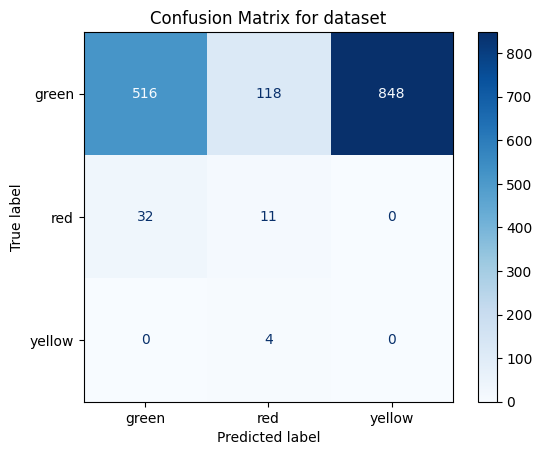

In [112]:
# Determine model scores for COMPACT predicting MNO
y_pred_hgb_c2m=hgb_compact.predict(X_clusters['mno']['X_test'])
_ = ml_util.get_model_scores(X_clusters['mno']['y_test'].astype('category'), y_pred_hgb_c2m)

ml_util.show_confusion_matrix(X_clusters['mno']['y_test'].astype('category'), y_pred_hgb_c2m)

           accuracy_score	0.9972206781545303
  balanced_accuracy_score	0.993176131076174
                 f1_score	0.9941073271975515
          precision_score	0.995045296816414
             recall_score	0.993176131076174
       mean_squared_error	0.0027793218454697055


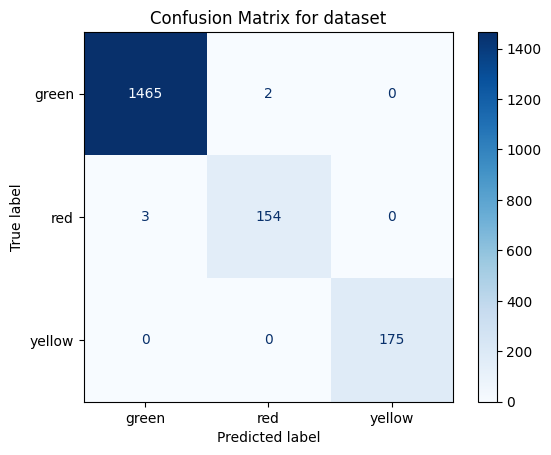

In [115]:
# Determine model scores for MNO predicting COMPACTS
y_pred_hgb_m2c=hgb_mno.predict(X_clusters['compact']['X_test'])
_ = ml_util.get_model_scores(X_clusters['compact']['y_test'].astype('category'), y_pred_hgb_m2c)

ml_util.show_confusion_matrix(X_clusters['compact']['y_test'].astype('category'), y_pred_hgb_m2c)

**Discussion**

From these results, we can see the multimode (MNO) cluster can be used to predict the compact cluster but not vice versa.

## Section 3: Analysis

These new results maintain the same pattern as before, where we can use a combined dataset to make predictions with great accuracy and performance for either of the cluster types. A similar pattern is found where the accuracy and performance of a model trained only on a compact cluster cannot predict the MNO, but the model trained on an MNO cluster can predict the compact cluster.

We can conclude from these experiments that the "model portability" we want to maintain should be trained on a combined dataset or a multinodes (MNO) cluster.

Understanding these results, we can now focus on predicting the tunable artifacts the cluster should apply to remain in a green state.

---

&copy; 2023 by [William Caban](https://www.linkedin.com/in/williamcaban/) licensed under [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1)<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a>